In [1]:
# To use TF 2.0 (on EC2 instance running Deep Learning AMI):
# source activate tensorflow_p36
# pip uninstall tensorflow-gpu
# pip install tensorflow-gpu==2.0.0-alpha0

# But then later decided wanted even newer GPU stuff and "in that conda env, ran:
# pip uninstall tensorflow-gpu
# pip install --upgrade pip
# pip install wrapt --ignore-installed # ran this because had an error
# pip install  tf-nightly-gpu-2.0-preview

# Result: Successfully installed tf-nightly-gpu-2.0-preview-2.0.0.dev20190601

In [2]:
import os
from datetime import datetime
import numpy as np
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
from packaging import version

print("TensorFlow version: ", tf.__version__) # make sure >= 2.0.0-dev20190605
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."


TensorFlow version:  2.0.0-dev20190605


In [5]:
import cs230_project_utilities as utils

In [6]:
# GPU usage logging (TF 2.0+)

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(False)

# Load dataset as TFRecords 

In [7]:
# Sync from remote storage in s3
# aws s3 sync s3://cs230-automap/data/fastmri/tfrecords cs230/data/fastmri/tfrecords

In [8]:
dev_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_dev/*.tfrecord'
test_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_test/*.tfrecord'
train_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_train/*.tfrecord'

In [9]:
# Use tf.data.Datasets to preprocess and iterate data efficiently

batch_size = 16

dev_dataset = utils.fastmri.load_dataset(dev_locations,
                                         batch_size=8,
                                         shuffle_buffer_size=128,
                                         load_original_reconstruction=False,
                                         include_all_parsed_features=False,
                                         ignore_errors=True,
                                         perform_data_augmentation=False)

test_dataset = utils.fastmri.load_dataset(test_locations,
                                          batch_size=8,
                                          shuffle_buffer_size=128,
                                          load_original_reconstruction=False,
                                          include_all_parsed_features=False,
                                          ignore_errors=True,
                                          perform_data_augmentation=False)

train_dataset = utils.fastmri.load_dataset(train_locations,
                                           batch_size=batch_size,
                                           shuffle_buffer_size=1024,
                                           load_original_reconstruction=False,
                                           include_all_parsed_features=False,
                                           ignore_errors=True,
                                           perform_data_augmentation=False)

Loading dataset... Shuffle items? True. Shuffle buffer: 128
Loading dataset... Shuffle items? True. Shuffle buffer: 128
Loading dataset... Shuffle items? True. Shuffle buffer: 1024


# Validate dataset
Make sure target reconstruction is the same as reconstruction computed from input.

In [10]:
# First batch of each dataset to be used in plotting images periodically to tensorboard

first_test_batch = next(iter(test_dataset))
first_dev_batch = next(iter(dev_dataset))
first_train_batch = next(iter(train_dataset))

In [11]:
def first_batches():
    batches = [(first_test_batch, 'Test'), (first_dev_batch, 'Dev'), (first_train_batch, 'Train')]
    return batches

In [12]:
first_test_batch[0].shape

TensorShape([8, 128, 128, 2])

In [13]:
fft, target_image = first_test_batch[0][0].numpy().squeeze(), first_test_batch[1][0].numpy().squeeze()
fft = utils.fastmri._combine_two_channels_of_complex_tensor(fft).numpy()

# Compute image from input `fft`
image_from_fft = tf.abs(utils.signal_processing.tf_ifft2d(fft)).numpy().squeeze()

# Compare target image to reconstruction from input `fft`
np.allclose(image_from_fft, target_image, atol=1e-6), utils.signal_processing.mean_square_error(image_from_fft, target_image)

(True, 2.2105097e-15)

In [14]:
# Should be in [0, 1]
image_from_fft.min(), image_from_fft.max(), target_image.min(), target_image.max()

(0.00027678022, 0.9999998, 0.0002767691, 0.99999994)

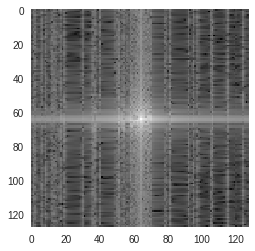

In [15]:
utils.plot.imshowfft(fft)

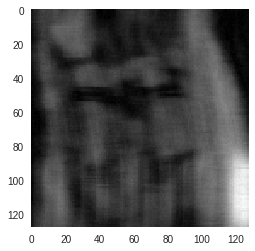

In [16]:
utils.plot.imshowgray(target_image)

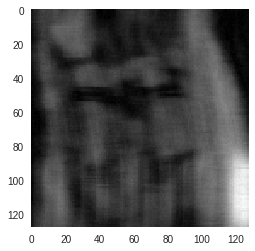

In [17]:
utils.plot.imshowgray(image_from_fft)

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


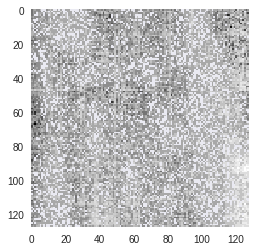

In [18]:
utils.plot.imshowfft(np.square(target_image - image_from_fft))

# Model

In [19]:
# A metric to use during training
def mean_PSNR(y_true, y_pred):
    max_value = 1.0
    MSE = tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2, 3])
    PSNR = 10 * tf.math.log(tf.divide(max_value ** 2, MSE)) / tf.math.log(tf.constant(10, dtype=y_pred.dtype))
    mean = tf.reduce_mean(PSNR)
    return mean

In [20]:
# Model most similar to OG AUTOMAP
# def load_uncompiled_automap_model():

#     N = 128
#     X = tf.keras.layers.Input(shape=(N, N, 2))

#     # Paper says 1% multiplicative gaussian noise (this multiplies by 1-centered gaussian
#     # having stddev = sqrt(rate / (1 - rate)) (here, 0.00032...)
#     # noisy_X = tf.keras.layers.GaussianDropout(rate=1e-7)(X) # spatial dimension: 256
#     # Note: (we could corrupt when training with cifar, but maybe not other dataset?)

#     ds_flat = tf.keras.layers.Flatten()(X)

# #     fc1 = tf.keras.layers.Dense(64 ** 2, activation='tanh')(ds_flat) # closer to original paper is: 128 ** 2
# #     fc1 = tf.keras.layers.Dropout(0.05)(fc1)
#     fc2 = tf.keras.layers.Dense(128 ** 2, activation='tanh')(ds_flat)

#     fc_output = tf.keras.layers.Reshape([128, 128, 1])(fc2)

#     conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same')(fc_output)
    
#     # L1 regularization to encourage sparsity
#     conv2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same',
#                                    activity_regularizer=tf.keras.regularizers.l1(1e-4))(conv1)

#     Y_pred = tf.keras.layers.Conv2DTranspose(1, (7, 7), strides=1, activation='relu', padding='same')(conv2) # upsample to spatial dimension 256

#     model = tf.keras.Model(inputs=X, outputs=Y_pred)

#     return model

In [ ]:
# def load_uncompiled_automap_model():
    
#     # this one's solid, but I believe we'll need a few hours to train it.
    
#     N = 128
#     F = 32
#     X = tf.keras.layers.Input(shape=(N, N, 2))

# #     Half-assed data augmentation
# #     noisy_X = tf.keras.layers.GaussianNoise(stddev=1e-7)(X) # shape: (N, N, 2)

#     # These layers all halve the spatial dimension (but also each output F channels)
#     conv1 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(X)])
#     pool1 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv1) # spatial dim: N / 2
    
#     conv2 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(pool1)])
#     pool2 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv2) # spatial dim: N / 4
    
#     conv3 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(pool2)])
#     pool3 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv3) # spatial dim: N / 8
    
#     conv4 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(pool3),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(pool3),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(pool3)])
#     # spatial dim: N / 4
    
#     conv5 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv4),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(conv4),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(conv4)])
#     # spatial dim: N / 2
    
#     conv6 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv5),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(conv5),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(conv5)])
#     # spatial dim: N
    
#     conv7 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(conv6)])
    
#     t_conv8 = tf.keras.layers.Conv2DTranspose(6 * F, 5, strides=1, activation='relu', padding='same',
#                                               # Encourage sparsity in output (MRI images are mostly zeros)
#                                               activity_regularizer=tf.keras.regularizers.l1(1e-6))(conv7)

#     Y_pred = tf.keras.layers.Conv2DTranspose(1, 7, strides=1, activation='relu', padding='same')(t_conv8) # spatial dim: 128

#     model = tf.keras.Model(inputs=X, outputs=Y_pred)

#     return model

In [83]:
def load_uncompiled_automap_model():
    
    # this one's solid, but I believe we'll need a few hours to train it.
    
    N = 128
    F = 128
    X = tf.keras.layers.Input(shape=(N, N, 2))

    # Half-assed data augmentation
    noisy_X = tf.keras.layers.GaussianNoise(stddev=1e-7)(X) # shape: (256, 256, 256)

    # These layers all halve the spatial dimension (but also each output 256 channels)
    conv1 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(X)
    pool1 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv1) # shape: (128, 128, F)

    conv2 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv2) # shape: (64, 64, F)

    conv3 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool2)
    pool3 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv3) # shape: (32, 32, F)

    conv4 = tf.keras.layers.Conv2D(2 * F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool3)
    pool4 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv4) # shape: (16, 16, F)

    conv5 = tf.keras.layers.Conv2D(2 * F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool4)
    pool5 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv5) # shape: (8, 8, F)

    # A "FC-like" layer for fun before we do upsampling
    conv7 = tf.keras.layers.Conv2D(2 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(pool5) # spatial dim: 4
    conv7 = tf.keras.layers.Conv2D(4 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(conv7) # spatial dim: 4
    conv7 = tf.keras.layers.Conv2D(2 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(conv7) # spatial dim: 4

    # These transposed convolutions upsample spatial dimension by 2
    t_conv1 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv7) # spatial dim: 8
    t_conv2 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv1) # spatial dim: 16
    t_conv3 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv2) # spatial dim: 32
    t_conv4 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv3) # spatial dim: 64
    t_conv5 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv4) # spatial dim: 128
    
    t_conv6 = tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same',
                                              # Encourage sparsity in output (MRI images are mostly zeros)
                                              activity_regularizer=tf.keras.regularizers.l1(1e-6))(t_conv5)
    
    Y_pred = tf.keras.layers.Conv2DTranspose(1, 7, strides=1, activation='relu', padding='same')(t_conv6) # spatial dim: 256

    model = tf.keras.Model(inputs=X, outputs=Y_pred)

    return model

In [84]:
def lr_schedule(epoch):
    initial_lr = 2e-4
    if epoch < 10:
        return initial_lr #2e-4
    elif epoch >= 10 and epoch < 30:
        return initial_lr / 2e0 #1e-4
    elif epoch >= 30 and epoch < 40:
        return initial_lr #2e-4
    elif epoch >= 40 and epoch < 50:
        return initial_lr / 2e0 #1e-4
    elif epoch >= 50 and epoch < 60:
        return initial_lr / 4e0 #5e-5
    elif epoch >= 60 and epoch < 80:
        return initial_lr / 2e1 #1e-5
    elif epoch >= 80 and epoch < 90:
        return initial_lr / 2e2 #1e-6
    else:
        return initial_lr / 2e3 #1e-7

In [85]:
def load_compiled_automap_model():
    multi_gpu = False
    if multi_gpu:
        # Distribute training across GPUs (each GPU receives identical updates to weights but different batches w/
        # mirrored strategy). Restricts callbacks we can use
        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            model = load_uncompiled_automap_model()
            optimizer = tf.keras.optimizers.Adam()
            model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    else:
        model = load_uncompiled_automap_model()
        optimizer = tf.keras.optimizers.Adam()
        model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    return model

In [86]:
model = load_compiled_automap_model()

In [87]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 2)]     0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 128, 128, 128)     2432      
_________________________________________________________________
average_pooling2d_63 (Averag (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 64, 64, 128)       147584    
_________________________________________________________________
average_pooling2d_64 (Averag (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
average_pooling2d_65 (Averag (None, 16, 16, 128)       0  

# Training

In [27]:
# Show reconstructions during training

def plot_fft_reconstructions(batch, logs):
    plot_frequency = 2500
    
    if batch % plot_frequency != 0:
        return
    
    for dataset_batch, name in first_batches():
        x, y = dataset_batch
        y = y.numpy()
        y_pred = model.predict(x)

        with file_writer.as_default():
            for i in range(min(len(y), 5)):
                prediction, ground_truth = y_pred[i:i + 1, ...], y[i:i + 1, ...]
                tf.summary.image("{} Image {} (Prediction)".format(name, i), prediction, max_outputs=1, step=batch)
                tf.summary.image("{} Image {} (Ground Truth)".format(name, i), ground_truth, max_outputs=1, step=batch)

In [28]:
# Show activation histograms

def layer_activations(inputs):
    layers = model.layers
    names = [l.name for l in layers]
    input_tensor = layers[0].input
    outputs = [l.output for l in layers]
    
    get_activations = tf.keras.backend.function(input_tensor, outputs)
    activations = get_activations(inputs=inputs)
    
    return list(zip(names, activations))

def plot_activations(batch, logs):
    plot_frequency = 2500
    
    if batch % plot_frequency != 0:
        return

    with file_writer.as_default():
        for dataset_batch, stage in first_batches():
            for layer_name, layer_activation in layer_activations(dataset_batch):
                tf.summary.histogram('{}/activations/{}'.format(layer_name, stage.lower()), layer_activation,
                                    step=batch)


In [29]:
# Clear logs and models if necessary
# !rm -r /home/ubuntu/cs230/logs/
# !rm -r /home/ubuntu/cs230/models

In [30]:
# Define where logs will be saved

logdir = os.path.join('/home/ubuntu/cs230/logs', datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))
file_writer = tf.summary.create_file_writer(os.path.join(logdir, 'metrics'))

### Callbacks to use in various stages of training

In [31]:
# Callback for printing the LR at the end of each epoch.

class PrintAndLogLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with file_writer.as_default():
            current_lr = model.optimizer.lr.numpy()
            tf.summary.scalar('learning rate', data=current_lr, step=epoch)
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, current_lr))

plot_images_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=plot_fft_reconstructions)

plot_activations_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=plot_activations)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq=2500,
                                                      profile_batch=0) # workaround for: https://github.com/tensorflow/tensorboard/issues/2084

set_lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=2, min_lr=1e-8)

# Callback for checkpointing model

# include the epoch in the file name. (uses `str.format`)
checkpoint_path = os.path.join('/home/ubuntu/cs230/models/automap_fastmri',
                               datetime.now().strftime("%Y-%m-%d_%H:%M:%S"),
                               'cp-{epoch:04d}.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # Save every K-batches
    save_freq=int(5e5))
model.save_weights(checkpoint_path.format(epoch=0))

callbacks = [tensorboard_callback, plot_images_callback, plot_activations_callback,
             set_lr_callback, reduce_lr_callback, PrintAndLogLR(), checkpoint_callback]

### Begin training and open Tensorboard to monitor

In [32]:
training_history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    verbose=1, # set to 0 to suppress chatty output and use Tensorboard instead
    epochs=150,
    callbacks=callbacks,
    use_multiprocessing=True) # see if speeds things up

Epoch 1/150
      1/Unknown - 19s 19s/step - loss: 0.0678 - mean_PSNR: 12.2637

W0607 00:34:42.734519 140445761623808 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (4.026434). Check your callbacks.


   2172/Unknown - 392s 181ms/step - loss: 0.0186 - mean_PSNR: 18.2985
Learning rate for epoch 1 is 0.00019999999494757503
2172/2172 [==============================] - 434s 200ms/step - loss: 0.0186 - mean_PSNR: 18.2985 - val_loss: 0.0000e+00 - val_mean_PSNR: 0.0000e+00
Epoch 2/150


W0607 00:41:43.502424 140445761623808 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (6.240331). Check your callbacks.


   1/2172 [..............................] - ETA: 4:02:13 - loss: 0.0129 - mean_PSNR: 19.6522

W0607 00:41:43.673682 140445761623808 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (3.120191). Check your callbacks.


1037/2172 [=============>................] - ETA: 3:20 - loss: 0.0126 - mean_PSNR: 19.7477

KeyboardInterrupt: 

### Save model (to do: make callback)

In [ ]:
# # # Uncomment to save model
saved_model_path = 'final_fast_mri_output'
model.save(saved_model_path)

## Evaluate model

In [ ]:
model.evaluate(test_dataset, verbose=1)
# model.evaluate(dev_dataset, verbose=1)
# model.evaluate(train_dataset, verbose=1)

### Plot training history (but better viewed in Tensorboard)

In [ ]:
plt.figure()
plt.plot(training_history.history["loss"], label="Train")
plt.plot(training_history.history["val_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="center right")

In [ ]:
plt.figure()
plt.plot(training_history.history["mean_PSNR"], label="Train")
plt.plot(training_history.history["val_mean_PSNR"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("µ ( PSNR ) ")
plt.legend(loc="center right")

In [ ]:
# Predict on a test batch

# batch = next(iter(test_dataset))

x, y = first_test_batch
x, y = x.numpy(), y.numpy()
y_pred = model.predict(x)

# Inspect output

for i in range(len(x)):

    fft_mag = x[i, ..., 0]
    fft_ang = x[i, ..., 1]
    reconstruction = y_pred[i, ..., 0]
    image = y[i, ..., 0]

    MSE = utils.signal_processing.mean_square_error(reconstruction, image)
    PSNR = utils.signal_processing.PSNR(reconstruction, image, max_value=max(image.max(), reconstruction.max()))

    plt.subplot(2, 2, 1)
    plt.title('Reconstruction (MSE: {:0.5f}, PSNR: {:0.5f})'.format(MSE, PSNR))
    utils.plot.imshowgray(reconstruction)

    plt.subplot(2, 2, 2)
    plt.title('FFT (Magnitude)')
    utils.plot.imshowfft(fft_mag)

    plt.subplot(2, 2, 3)
    plt.title('Expected reconstruction')
    utils.plot.imshowgray(image)

    plt.subplot(2, 2, 4)
    plt.title('FFT (Phase)')
    utils.plot.imshowgray(fft_ang)

    plt.show()
    break


In [ ]:
utils.plot.imshowgray(y_pred[0].squeeze())

In [ ]:
utils.plot.imshowgray(y[0].squeeze())